In [1]:
import os
import time
import sys
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import save_model
from utils.data import train_val_generator,test_generator,pred_generator
from utils.imageplot import plot, plot2

In [12]:
train_gen = train_val_generator(
    data_dir='./imagenette/train',
    target_size=(224,224),
    batch_size=18,
    class_mode='categorical',
    subset='training'
)
#classes
class_names = list(train_gen.class_indices.keys())
print(class_names)

Found 7578 images belonging to 10 classes.
['n01440764', 'n02102040', 'n02979186', 'n03000684', 'n03028079', 'n03394916', 'n03417042', 'n03425413', 'n03445777', 'n03888257']


In [13]:
val_gen = train_val_generator(
data_dir='./imagenette/train',
    target_size=(224,224),
    batch_size=18,
    class_mode='categorical',
    subset='validation'
)

Found 1891 images belonging to 10 classes.


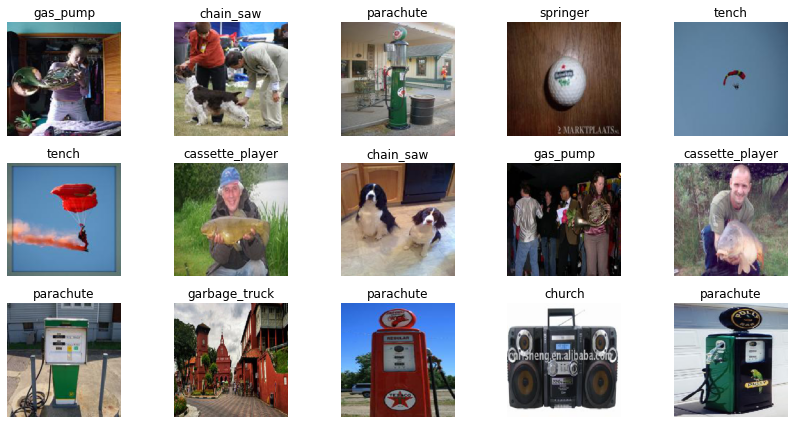

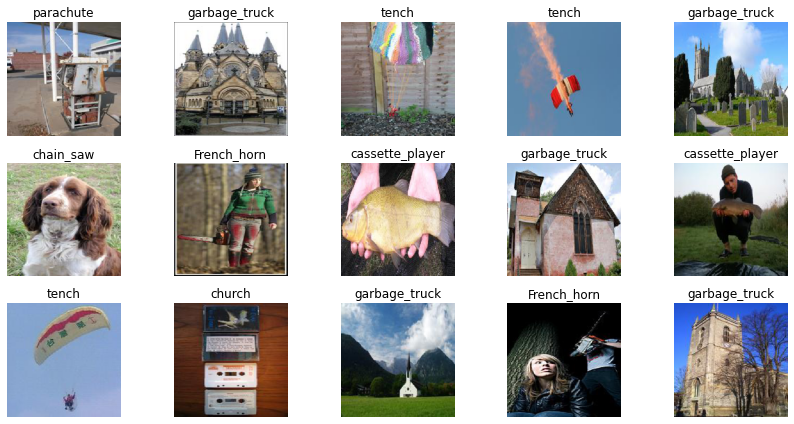

In [16]:
train_batch,train_label_batch = train_gen.next()
#plot train set
plot(train_batch,train_label_batch,class_names2)
val_batch,val_label_batch = val_gen.next()
#plot val set
plot(val_batch,val_label_batch,class_names2)

In [17]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import activations
from tensorflow.keras import layers

In [18]:
class before_tail(Model):
    def __init__(self, filters):
        super(before_tail, self).__init__()
    # input 224 * 224 * 3
    # filters 64
        self.filters = filters
        self.c1 = layers.Conv2D(filters//2, kernel_size=(3,3), strides=(2,2), use_bias=False,padding='same')
        self.b1 = layers.BatchNormalization()
        self.a1 = layers.Activation('relu')

        self.c2 = layers.Conv2D(filters//2, kernel_size=3, strides=1, padding="same",
                                 use_bias=False)        
        self.b2 = layers.BatchNormalization()
        self.a2 = layers.Activation('relu')

        self.c3 = layers.Conv2D(filters, kernel_size=3, strides=1, use_bias=False, padding='same')
        self.b3 = layers.BatchNormalization()
        self.a3 = layers.Activation('relu')

        self.max = layers.MaxPool2D(pool_size=3, strides=2, padding='same')

    def call(self,inputs):
        x = self.c1(inputs)
        x = self.b1(x)
        x = self.a1(x)
        x = self.c2(x)
        x = self.b2(x)
        x = self.a2(x)
        x = self.c3(x)
        x = self.b3(x)
        x = self.a3(x)
        y = self.max(x)
        return y

        



In [19]:
def get_filters(inputs):
  _,_,_,c = inputs.shape
  return c



  
class Bottelneck(Model):
  def __init__(self, filters, strides=1, mode='NORM',k=1):
    super(Bottelneck, self).__init__()
    # self.in_filters = get_filters(inputs)
    self.k = k
    self.filters = filters
    self.strides = strides
    self.b1 = layers.BatchNormalization()
    self.a1 = layers.Activation('relu')
    self.c1 = layers.Conv2D(filters//4, kernel_size=1, strides=1, padding='same', use_bias=False)

    self.b2 = layers.BatchNormalization()
    self.a2 = layers.Activation('relu')
    self.c2 = layers.Conv2D(filters//4, kernel_size=3, strides=1, padding='same', use_bias=False)

    self.b3 = layers.BatchNormalization()
    self.a3 = layers.Activation('relu')
    self.c3 = layers.Conv2D(filters, kernel_size=1, strides=1, padding='same', use_bias=False)
    self.cr = layers.Conv2D(filters, 1, strides=self.strides, padding='same', use_bias=False)
    self.mode = mode

  def call(self,inputs):
    in_filters = get_filters(inputs)
    residual = inputs   
    x = self.b1(inputs)
    x = self.a1(x)
    x = self.c1(x)

    x = self.b2(x)
    x = self.a2(x)
    x = self.c2(x)

    x = self.b3(x)
    x = self.a3(x)
    x = self.c3(x)


    if self.mode == 'UP':

      residual = self.squeeze_idt(residual)

    elif in_filters != self.filters or self.strides >1 :
      residual = self.b1(residual)
      residual = self.a1(residual)
      residual = self.cr(residual) 

    out = x+residual

    return out
  
  def squeeze_idt(self, inputs):
    _,h,w,c = inputs.shape
    outputs = tf.reduce_sum(tf.reshape(inputs,[-1,h,w,c//self.k, self.k]), axis=4)
    return outputs

class Bottelneck_block(Model):
  def __init__(self, filters, blocks, strides, mode, k):
    super(Bottelneck_block, self).__init__()
    self.block = tf.keras.models.Sequential()
    self.k = k

    if mode == 'UP':
      block1 = Bottelneck(filters,strides=1, mode=mode,k=self.k)
    else:
      block1 =Bottelneck(filters, strides=1, mode='NORM', k=1)
    
    self.block.add(block1)
    for _ in range(1,blocks):
      block = Bottelneck(filters, strides=1, mode='NORM', k=1)
      self.block.add(block)
  
  def call(self,inputs):
    x = self.block(inputs)
    return x
  



In [20]:
class make_tail(Model):
  def __init__(self, channels, res_blocks):
    super(make_tail, self).__init__()
    # channels = 128, 256, 512
    # res blocks = 2,2,6
    t1_channel, t2_channel, t3_channel = channels
    t1_res_blks, t2_res_blks, t3_res_blks = res_blocks

    self.block1 = Bottelneck_block(t1_channel, t1_res_blks, 1, 'NORM',k=1)
    self.d1= layers.MaxPool2D(pool_size=2, strides=2, padding='same')
    
    self.block2 = Bottelneck_block(t2_channel, t2_res_blks, 1,'NORM',k=1)
    self.d2 = layers.MaxPool2D(pool_size=2, strides=2, padding='same')

    self.block3 = Bottelneck_block(t3_channel, t3_res_blks, 1, 'NORM',k=1)
    self.d3 = layers.MaxPool2D(pool_size=2, strides=2, padding='same')
  
  def call(self,inputs):
      x = self.block1(inputs)
      tail1_out = self.d1(x)

      x = self.block2(tail1_out)
      tail2_out = self.d2(x)

      x = self.block3(tail2_out)

      tail3_out = self.d3(x)

      return (tail3_out, tail2_out, tail1_out)


In [21]:
def _make_se_score_feats(out_filters):
    # in_filters = get_filters(inputs)
    model = tf.keras.models.Sequential()
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Conv2D(out_filters//2, kernel_size=1, strides=1, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Conv2D(out_filters, kernel_size=1, strides=1, padding='same'))
    return model
def squeeze():
  model = tf.keras.models.Sequential()
  model.add(layers.BatchNormalization())
  model.add(layers.Activation('relu'))
  model.add(layers.AveragePooling2D(pool_size=(7,7), strides=1)) # do i need padding here?
  # need to squeeze the output of squeeze
  return model

def get_scale(ratio, channels):
    model = tf.keras.models.Sequential()
    model.add(layers.Dense(units=channels//ratio, activation='relu'))
    model.add(layers.Dense(units=channels, activation='sigmoid'))
    ## need to exppand dims two times 
    return model
    
class se_block(Model):
  def __init__(self, channels, res_blocks, se_ratio):
    super(se_block, self).__init__()
  # blocks = 2, channels = 512, se_ratio = 16 infilters = 512
  # input should be 7*7*512
  # se_block ouputshpae shoud be 7*7*512
    self.blocks = res_blocks
    self.channels = channels
    self.se_ratio = se_ratio
    self.in_filters = 512
    self.score_feats = _make_se_score_feats(self.in_filters*2)
    self.squeezed = squeeze()
    self.scales = get_scale(self.se_ratio, self.channels)
    self.out = Bottelneck_block(self.in_filters, blocks=self.blocks, strides=1, mode='NORM', k=1)
  def call(self,inputs):
    x = self.score_feats(inputs)
    x = self.squeezed(x)   
    x = tf.squeeze(x, axis=[1,2])   
    x = self.scales(x) 
    x = tf.expand_dims(x, axis=1)
    x = tf.expand_dims(x, axis=1)
    scale = x 
    y = self.out(inputs) * scale + scale
    return y
    
    

In [22]:
class make_body(Model):
  def __init__(self, channels, res_blocks, trans_blocks):
    super(make_body, self).__init__()
    # channels 512, 384, 256
    # res blocks 1,1,1
    # trans blocks 1,1,1
    b1_channel, b2_channel, b3_channel = channels

    b1_res_blks, b2_res_blks, b3_res_blks = res_blocks

    b1_trans_blks, b2_trans_blks, b3_trans_blks = trans_blocks
 
    self.body1 = Bottelneck_block(filters=b1_channel, blocks=b1_res_blks, strides=1, mode='UP',k=1)

    self.body2 = Bottelneck_block(filters=384, blocks=b2_res_blks, strides=1, mode='UP',k=2)

    self.body3 = Bottelneck_block(filters=256, blocks=b3_res_blks, strides=1, mode='UP',k=2)
    # transfer block
    self.transfer0 = Bottelneck_block(filters=512, blocks=b1_trans_blks, strides=1, mode='NORM', k=1)
    self.tranfer1 = Bottelneck_block(filters=256, blocks= b1_trans_blks, strides=1, mode='NORM',k=1)
    self.transfer2 = Bottelneck_block(filters=128, blocks=b2_trans_blks, strides=1, mode='NORM',k=1)


  def call(self, input, in_transfer1, in_transfer2):
# body 1
    
    x = self.transfer0(input)

    x = self.body1(input)
  # upsample
    _,h,w,_ = x.shape
    out1 = tf.image.resize(x,[2*h,2*w],method='nearest')

# body 2
    in_transfer1 = self.tranfer1(in_transfer1)
    in2 = tf.concat(values=[out1, in_transfer1], axis=3)
    x2 = self.body2(in2)
  # upsample
    _,h,w,_ = x2.shape
    out2 = tf.image.resize(x2,[2*h,2*w],method='nearest')

# body 3
    in_transfer2 = self.transfer2(in_transfer2)
    in3 = tf.concat(values=[out2,in_transfer2], axis=3)
    x3 = self.body3(in3)
  # upsample
    _,h,w,_ = x3.shape
    out3 = tf.image.resize(x3,[2*h,2*w],method='nearest')
    
  

    return (out3, in3, in2)




In [23]:
class make_head(Model):
  def __init__(self, channels, res_blocks, trans_blocks, num_class):
    super(make_head, self).__init__()
    # filters : 320 832 1600
    # res blocks 1 2 2
    # trans blocks 1 1 4
    h1_channel, h2_channel, h3_channel  = channels
    h1_res_blks, h2_res_blks, h3_res_blks = res_blocks
    h1_trans_blks, h2_trans_blks, h3_trans_blks = trans_blocks

    self.h1 = Bottelneck_block(filters=h1_channel, blocks=h1_res_blks, mode='NORM',strides=1,k=1)
    self.d1 = layers.MaxPool2D(pool_size=2, strides=2, padding='same')
    self.h2 = Bottelneck_block(filters=h2_channel, blocks=h2_res_blks, mode='NORM',strides=1,k=1)

    self.h3 = Bottelneck_block(filters=h3_channel, blocks=h3_res_blks, mode='NORM',strides=1,k=1)

    # transfer block
    self.t1 = Bottelneck_block(filters=64, blocks=h1_trans_blks, mode='NORM', strides=1,k=1)
    self.t2 = Bottelneck_block(filters=512, blocks=h2_trans_blks, mode='NORM', strides=1,k=1)
    self.t3 = Bottelneck_block(filters=768, blocks=h3_trans_blks, mode='NORM', strides=1,k=1)
    # score
    self.b = layers.BatchNormalization()
    self.a = layers.Activation('relu')
    self.c = layers.Conv2D(800, kernel_size=1, strides=1, padding='same')
    self.squeeze = squeeze()
    self.dense = layers.Dense(units=num_class, activation='softmax')
  def call(self, input, t_1,t_2,t_3):
    t_1 = self.t1(t_1)
    in_1 = tf.concat(values=[input, t_1], axis=3)
    out_1 = self.h1(in_1)
    out_1 = self.d1(out_1)

    t_2 = self.t2(t_2)
    in_2 = tf.concat(values=[out_1, t_2], axis=3)
    out_2 = self.h2(in_2)
    out_2 = self.d1(out_2)


    t_3 = self.t3(t_3)
    in_3 = tf.concat(values=[out_2, t_3], axis=3)
    out_3 = self.h3(in_3)
    out_3 = self.d1(out_3)

    score = self.b(out_3)
    score = self.a(score)
    score = self.c(score)
    score = self.squeeze(score)
    score = tf.squeeze(score, axis=[1,2])
    score = self.dense(score)




    return score


In [24]:
class Fishnet(Model):
  def __init__(self, channels, res_blocks, trans_blocks, num_class, se_ratio):
    super(Fishnet, self).__init__()
    self.initial = before_tail(channels[0])
    self.tail  = make_tail(channels= channels[1:4], res_blocks=res_blocks[0:3])
    self.se = se_block(channels=channels[4], res_blocks=res_blocks[3], se_ratio=se_ratio)
    self.body = make_body(channels=channels[5:8], res_blocks=res_blocks[4:7],trans_blocks=trans_blocks[0:3])
    self.head = make_head(channels=channels[8:],res_blocks=res_blocks[7:], trans_blocks=trans_blocks[3:],num_class=num_class)

  def call(self, inputs):
    beforetail = self.initial(inputs)

    tail1, tail2, tail3 = self.tail(beforetail)

    squeeze_excitation = self.se(tail1)

    bout, bt1, bt2 = self.body(squeeze_excitation, tail2, tail3)
    x = self.head(bout, beforetail, bt1, bt2)
    return x

In [25]:

def Fishnet99(num_classes):
  channels = [64,128,256,512,512,512,384,256,320,832,1600]
  res_blocks = [2,2,6,2,1,1,1,1,2,2]
  trans_blocks=[1,1,1,1,1,4]
  se_ratio = 16
  num_class = num_classes
  return Fishnet(channels, res_blocks, trans_blocks, num_class, se_ratio)
def Fishnet150(num_classes):
  channels = [64,128,256,512,512,512,384,256,320,832,1600]
  res_blocks = [2, 4, 8, 4, 2, 2, 2, 2, 2, 4]
  trans_blocks=[2, 2, 2, 2, 2, 4]
  se_ratio = 16
  num_class = num_classes
  return Fishnet(channels, res_blocks, trans_blocks, num_class, se_ratio)

def Fishnet201(num_classes):
  channels = [64,128,256,512,512,512,384,256,320,832,1600]
  res_blocks = [3, 4, 12, 4, 2, 2, 2, 2, 3, 10]
  trans_blocks=[2, 2, 2, 2, 2, 9]
  se_ratio = 16
  num_class = num_classes
  return Fishnet(channels, res_blocks, trans_blocks, num_class, se_ratio)





In [ ]:
num_classes = 10
model = Fishnet201(num_classes)
#model = tf.keras.models.load_model('./dune/model/fish-160-2')
model.compile(
    loss = 'categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),
    metrics = ['accuracy']
)

checkpoint_path = './checkpoint/Fishnet201.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_best_only=True)

history = model.fit(x=train_gen,steps_per_epoch=421,
                    epochs=20,validation_data=val_gen,
                    shuffle=True,
                    callbacks=[cp_callback])

Epoch 1/20
421/421 [==============================] - 248s 561ms/step - loss: 2.2327 - accuracy: 0.2625 - val_loss: 2.9568 - val_accuracy: 0.3249
Epoch 2/20
421/421 [==============================] - 232s 552ms/step - loss: 1.4653 - accuracy: 0.5055 - val_loss: 1.7715 - val_accuracy: 0.4518
Epoch 3/20
421/421 [==============================] - 233s 553ms/step - loss: 1.1629 - accuracy: 0.6168 - val_loss: 1.5599 - val_accuracy: 0.5325
Epoch 4/20
421/421 [==============================] - 233s 552ms/step - loss: 0.9272 - accuracy: 0.6928 - val_loss: 1.0102 - val_accuracy: 0.6756
Epoch 5/20
421/421 [==============================] - 233s 553ms/step - loss: 0.7300 - accuracy: 0.7584 - val_loss: 1.0758 - val_accuracy: 0.6394
Epoch 6/20
421/421 [==============================] - 233s 554ms/step - loss: 0.6021 - accuracy: 0.8060 - val_loss: 1.1659 - val_accuracy: 0.6378
Epoch 7/20
421/421 [==============================] - 233s 552ms/step - loss: 0.4889 - accuracy: 0.8309 - val_loss: 0.9574 -

In [ ]:
model.summary()

Model: "fishnet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
before_tail (before_tail)    multiple                  29024     
_________________________________________________________________
make_tail (make_tail)        multiple                  1995520   
_________________________________________________________________
se_block (se_block)          multiple                  1409056   
_________________________________________________________________
make_body (make_body)        multiple                  938496    
_________________________________________________________________
make_head (make_head)        multiple                  11160810  
Total params: 15,532,906
Trainable params: 15,476,138
Non-trainable params: 56,768
_________________________________________________________________


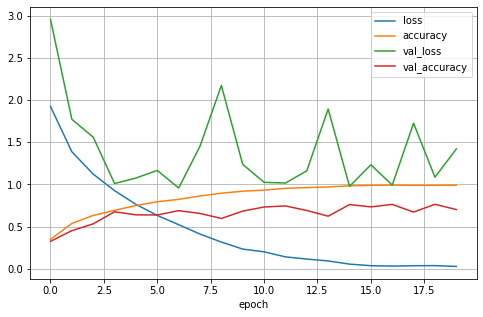

In [25]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.xlabel('epoch')
plt.show()

In [27]:
test_gen = test_generator(
    data_dir='./imagenette/val',
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical'
)
class_names = list(train_gen.class_indices.keys())
print(class_names)

Found 9469 images belonging to 10 classes.
['n01440764', 'n02102040', 'n02979186', 'n03000684', 'n03028079', 'n03394916', 'n03417042', 'n03425413', 'n03445777', 'n03888257']


In [28]:
pred_gen = pred_generator(
    data_dir='./imagenette/val',
    target_size=(224,224),
    batch_size=32,
    class_mode=None
)
class_names = list(train_gen.class_indices.keys())
print(class_names)

Found 9469 images belonging to 10 classes.
['n01440764', 'n02102040', 'n02979186', 'n03000684', 'n03028079', 'n03394916', 'n03417042', 'n03425413', 'n03445777', 'n03888257']


296/296 [==============================] - 75s 253ms/step - loss: 0.8498 - accuracy: 1.5642
测试集的损失是：0.8498098850250244，准确率accuracy:1.5641891956329346
预测集一个batch 15张图片的预测结果： [[8.47376336e-10 9.99999762e-01 3.60648067e-10 9.43640472e-08
  6.80258367e-12 3.06368750e-11 9.77232392e-11 1.31809813e-07
  5.46444730e-11 5.54366064e-09]
 [9.98351097e-01 5.05601529e-05 5.43175318e-08 1.57559081e-03
  6.86284096e-09 5.12178360e-07 4.31297212e-06 2.86342640e-07
  5.66620088e-07 1.70194780e-05]
 [4.29562206e-04 3.35048331e-04 3.23849599e-05 2.23957568e-01
  9.88861066e-05 7.37692535e-01 5.16302418e-03 3.22744399e-02
  3.71021507e-08 1.66166501e-05]
 [2.87436683e-06 7.15028727e-05 1.61091108e-07 9.99414325e-01
  3.36628236e-09 3.51759559e-06 2.09089899e-06 5.05648379e-04
  7.91803900e-10 3.53443386e-09]
 [6.49399939e-04 1.72509953e-01 8.03394616e-01 4.22177510e-03
  9.05361262e-08 1.46671981e-02 1.11580717e-04 3.23447678e-03
  2.33161772e-04 9.77773918e-04]
 [9.99226689e-01 1.38359255e-05 4.04685241

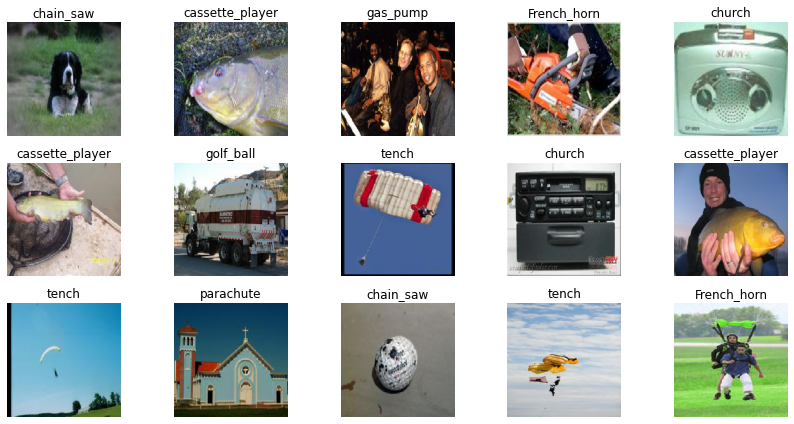

In [29]:
#loss,accuracy = loaded_model.evaluate(x=test_gen)
loss, accuracy = model.evaluate(x=test_gen)
print('the loss of testing:{0}，the accuracy:{1}'.format(loss,accuracy))
#get a prediction set of a batch siz
pred_batch = pred_gen.next()
#predict
pred_result = model.predict(x=pred_batch)
print('The prediction results of a batch of 15 images in the prediction set:',pred_result)
#visualization
plot2(pred_batch,pred_result)